In [8]:
import os
import torch
from tqdm import tqdm
from transformers import T5ForConditionalGeneration, T5Tokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datasets import load_dataset

# T5 모델과 토크나이저 불러오기
model_name = 'google/flan-t5-base'
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
tokenizer = T5Tokenizer.from_pretrained(model_name)

# boolQ 데이터셋 불러오기
dataset = load_dataset('HuggingFaceH4/databricks_dolly_15k')

import pandas as pd
from datasets import DatasetDict, Dataset

df = pd.DataFrame(dataset['train'][:20])
data = Dataset.from_pandas(df, preserve_index=False)
dataset = DatasetDict({'train':data})
dataset

# 데이터셋에 대한 반복문
def model_output_by_category(category_name, column_name):
    output_list = []
    for example in tqdm(dataset['train']):
        # 예시 문장과 정답 불러오기
        category = example['category']
        if category == category_name:
            context = example['input']
            question = example['instruction']
            answer = example['output']
            # T5 모델 입력을 위한 전처리
            inputs = tokenizer.encode_plus(question, context, return_tensors='pt', max_length=512, truncation=True).to(device)
            # T5 모델로 문제 답변 생성
            answer_ids = model.generate(inputs['input_ids'], num_beams=5, early_stopping=True, max_length=512, no_repeat_ngram_size=1)
            predicted_answer = tokenizer.decode(answer_ids[0], skip_special_tokens=True)
            output_list.append(predicted_answer)
    df_out = pd.DataFrame(output_list)
    os.makedirs(f'./d_{model_name}', exist_ok=True)
    df_out.to_csv(f'./d_{model_name}/{category_name}.csv', index=False)
    return output_list       

category_list = df['category'].value_counts().keys().tolist()
for cat in category_list:
    model_output_by_category(cat, "instruction")

Found cached dataset parquet (/home/uj-user/.cache/huggingface/datasets/HuggingFaceH4___parquet/HuggingFaceH4--databricks_dolly_15k-6252f3495e7d2b9d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 266.31it/s]


In [2]:
category_list

['open_qa',
 'information_extraction',
 'closed_qa',
 'classification',
 'brainstorming',
 'general_qa',
 'summarization']

In [9]:
import benepar
benepar.download('benepar_en3')

[nltk_data] Downloading package benepar_en3 to /home/uj-
[nltk_data]     user/nltk_data...
[nltk_data]   Unzipping models/benepar_en3.zip.


True

In [1]:
import re
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

nlp = spacy.load("en_core_web_sm")
if spacy.__version__.startswith('2'):
    nlp.add_pipe(benepar.BeneparComponent("benepar_en3"))
else:
    nlp.add_pipe("benepar", config={"model": "benepar_en3"})
    
        
def extract_root_verb_noun_pairs(sentence):
    verb = ""
    noun = ""

    sentence = re.sub(r"[^a-zA-Z0-9\s]", "", sentence)
    doc = nlp(sentence)

    for token in doc:
        if token.dep_ == "ROOT":
            verb = token.lemma_
            break
    for token in doc:
        if token.dep_ == "nsubj" or token.dep_ == "nsubjpass":
            noun = token.text
            break
    
    return f"{verb}-{noun}"

import matplotlib.pyplot as plt

def visualize_root_verb_noun_pairs(dataset):
    root_verb_noun_pairs = {}
    for sentence in dataset:
        pair = extract_root_verb_noun_pairs(sentence)
        if pair.split("-")[0] != "" and pair.split("-")[1] != "":
            if pair not in root_verb_noun_pairs:
                root_verb_noun_pairs[pair] = 1
            else:
                root_verb_noun_pairs[pair] += 1

    pairs = list(root_verb_noun_pairs.keys())
    counts = list(root_verb_noun_pairs.values())
    sorted_indices = sorted(range(len(counts)), key=lambda i: counts[i], reverse=True)
    sorted_pairs = [pairs[i] for i in sorted_indices]
    sorted_counts = [counts[i] for i in sorted_indices]

    plt.figure(figsize=(10, 6))
    plt.bar(sorted_pairs[:60], sorted_counts[:60])
    plt.title("The root verb-noun pairs")
    plt.xticks(rotation=90)
    plt.xlabel("Pair")
    plt.ylabel("Count")
    plt.savefig(f'./d_{model}/count_{category}.png')
    
    # verb와 noun 분리
    verb_list = [x.split("-")[0] for x in sorted_pairs]
    noun_list = [x.split("-")[1] for x in sorted_pairs]

    # verb와 noun 빈도수 계산
    verb_counter = Counter(verb_list)
    noun_counter = Counter(noun_list)
    verb_df = pd.DataFrame.from_dict(verb_counter, orient='index', columns=['count'])
    noun_df = pd.DataFrame.from_dict(noun_counter, orient='index', columns=['count'])

    # verb 빈도수에 따른 파이차트 생성
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    verb_df[:30].plot(kind='pie', y='count', ax=axs[0], autopct='%1.1f%%', startangle=90, shadow=False, legend=False, fontsize=8)
    axs[0].set_title("The root verbs 빈도수", fontsize=8)
    axs[0].set_ylabel("")

    # noun 빈도수에 따른 파이차트 생성
    noun_df[:30].plot(kind='pie', y='count', ax=axs[1], autopct='%1.1f%%', startangle=90, shadow=False, legend=False, fontsize=8)
    axs[1].set_title("The root nouns 빈도수", fontsize=8)
    axs[1].set_ylabel("")

    # 높은 빈도수 순서대로 The root verb-noun pairs 출력
    counter = Counter(data)
    post_sorted_pairs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    print("높은 빈도수 순서대로 The root verb-noun pairs")
    for pair, count in post_sorted_pairs:
        print(f"{pair}: {count}")
    return sorted_pairs, sorted_counts

dataset = [
    "The cat is sleeping on the sofa",
    "The dog is barking at the mailman",
    "The bird is flying in the sky",
    "The dog is barking at the mailman",
    "The bird is flying in the sky",
    "The fish is swimming in the pond",
    "The fish is working in the pond",
    "The book is on the table",
    "The computer is on the desk",
    "The phone is ringing",
    "The car is parked in the garage",
    "The tree is growing in the yard",
    "The sun is shining in the sky",
]


model_list = ['google/t5-v1_1-small', 'google/t5-v1_1-base', 'google/t5-v1_1-large' 'google/t5-v1_1-xl',
              'google/flan-t5-small', 'google/flan-t5-base', 'google/flan-t5-large' 'google/flan-t5-xl'
              ]
category_list = ['open_qa', 'general_qa', 'classification', 'closed_qa', 'brainstorming', 'information_extraction', 'summarization', 'creative_writing']
                 
# for model in model_list:
#     for category in category_list: 

model =   'google/flan-t5-base'
category = 'open_qa'
df = pd.read_csv(f'./d_{model}/{category}.csv')
data = df['0'].dropna().tolist()
print(len(dataset))
sorted_pairs, sorted_counts = visualize_root_verb_noun_pairs(data)

ValueError: [E002] Can't find factory for 'benepar' for language English (en). This usually happens when spaCy calls `nlp.create_pipe` with a custom component name that's not registered on the current language class. If you're using a Transformer, make sure to install 'spacy-transformers'. If you're using a custom component, make sure you've added the decorator `@Language.component` (for function components) or `@Language.factory` (for class components).

Available factories: attribute_ruler, tok2vec, merge_noun_chunks, merge_entities, merge_subtokens, token_splitter, doc_cleaner, parser, beam_parser, lemmatizer, trainable_lemmatizer, entity_linker, ner, beam_ner, entity_ruler, tagger, morphologizer, senter, sentencizer, textcat, spancat, spancat_singlelabel, future_entity_ruler, span_ruler, textcat_multilabel, en.lemmatizer

In [7]:
import nltk
from nltk.tokenize import word_tokenize
# nltk.download('averaged_perceptron_tagger')


# 입력 문장 정의
input_text = "The cat sat on the mat."

# 입력 문장 토크나이징 및 POS 태그 추출
tokens = nltk.word_tokenize(input_text)
pos_tags = nltk.pos_tag(tokens)

# 동사-명사 쌍 추출
verb_noun_pairs = []
for i in range(len(pos_tags)-1):
    if pos_tags[i][1].startswith('V') and pos_tags[i+1][1].startswith('N'):
        verb_noun_pairs.append(pos_tags[i][0] + ' ' + pos_tags[i+1][0])

# 동사-명사 쌍 출력
print(verb_noun_pairs)


[]


높은 빈도수 순서대로 The root verb-noun pairs
be-they: 1
jessie-: 1
States-: 1
polygon-: 1
ten-: 1


/home/uj-user/Yo/torch-venv/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  func(*args, **kwargs)
/home/uj-user/Yo/torch-venv/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  func(*args, **kwargs)
/home/uj-user/Yo/torch-venv/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*args, **kwargs)
/home/uj-user/Yo/torch-venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/uj-user/Yo/torch-venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/uj-user/Yo/torch-venv/lib/

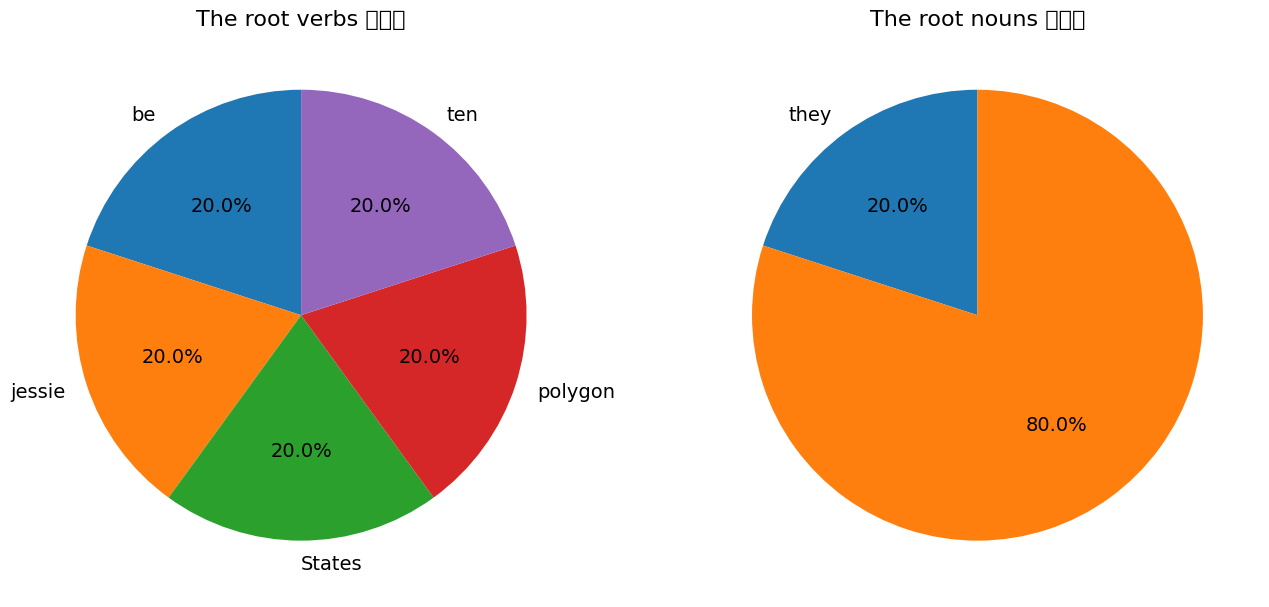

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# The root verb-noun pairs 데이터셋
# data = [
#     "is-sleeping",
#     "is-barking",
#     "is-flying",
#     "is-swimming",
#     "is-on",
#     "is-parked",
#     "is-growing",
#     "is-shining",
#     "is-ringing",
#     "is-ringing"
# ]

data = sorted_pairs

# verb와 noun 분리
verb_list = [x.split("-")[0] for x in data]
noun_list = [x.split("-")[1] for x in data]

# verb와 noun 빈도수 계산
verb_counter = Counter(verb_list)
noun_counter = Counter(noun_list)
verb_df = pd.DataFrame.from_dict(verb_counter, orient='index', columns=['count'])
noun_df = pd.DataFrame.from_dict(noun_counter, orient='index', columns=['count'])

# verb 빈도수에 따른 파이차트 생성
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
verb_df.plot(kind='pie', y='count', ax=axs[0], autopct='%1.1f%%', startangle=90, shadow=False, legend=False, fontsize=14)
axs[0].set_title("The root verbs 빈도수", fontsize=16)
axs[0].set_ylabel("")

# noun 빈도수에 따른 파이차트 생성
noun_df.plot(kind='pie', y='count', ax=axs[1], autopct='%1.1f%%', startangle=90, shadow=False, legend=False, fontsize=14)
axs[1].set_title("The root nouns 빈도수", fontsize=16)
axs[1].set_ylabel("")

# 높은 빈도수 순서대로 The root verb-noun pairs 출력
counter = Counter(data)
post_sorted_pairs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
print("높은 빈도수 순서대로 The root verb-noun pairs")
for pair, count in post_sorted_pairs:
    print(f"{pair}: {count}")

Output Sequence Length 최빈값: 25
Output Sequence Length 중앙값: 3.0
Output Sequence Length 평균값: 2.80


/home/uj-user/Yo/torch-venv/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  func(*args, **kwargs)
/home/uj-user/Yo/torch-venv/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  func(*args, **kwargs)
/home/uj-user/Yo/torch-venv/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*args, **kwargs)
/home/uj-user/Yo/torch-venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/uj-user/Yo/torch-venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/uj-user/Yo/torch-venv/lib/

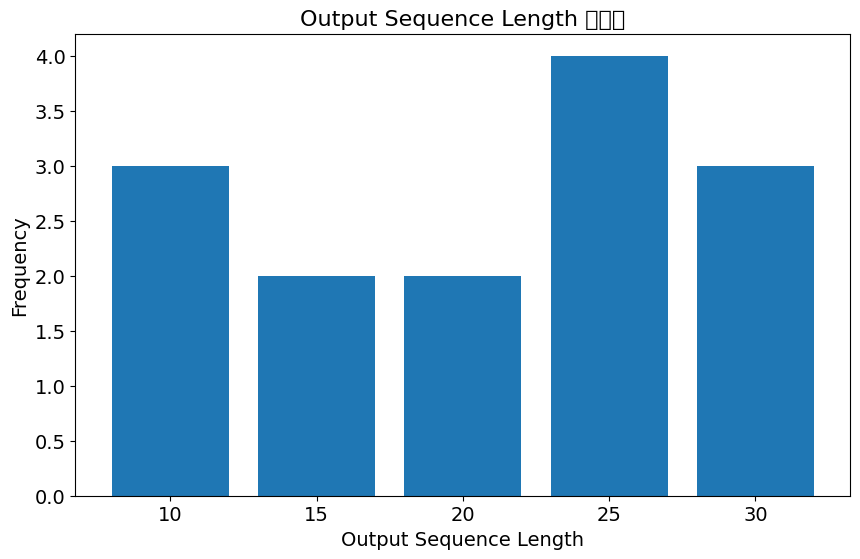

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# 모델의 출력된 문장 Output Sequence Length 데이터셋
data = [
    10,
    15,
    20,
    10,
    25,
    30,
    25,
    15,
    20,
    25,
    10,
    30,
    25,
    30
]

# Output Sequence Length 빈도수 계산
length_counter = Counter(data)
length_df = pd.DataFrame.from_dict(length_counter, orient='index', columns=['count'])
length_df = length_df.sort_index()

# Output Sequence Length 빈도수에 따른 막대그래프 생성
fig, axs = plt.subplots(figsize=(10, 6))
length_df.plot(kind='bar', y='count', ax=axs, legend=False, fontsize=14, width=0.8)
axs.set_title("Output Sequence Length 빈도수", fontsize=16)
axs.set_xlabel("Output Sequence Length", fontsize=14)
axs.set_ylabel("Frequency", fontsize=14)
plt.xticks(rotation=0)

# Output Sequence Length 최빈값, 중앙값, 평균값 출력
mode = length_df.idxmax()['count']
median = length_df.median()['count']
mean = length_df.mean()['count']
print(f"Output Sequence Length 최빈값: {mode}")
print(f"Output Sequence Length 중앙값: {median}")
print(f"Output Sequence Length 평균값: {mean:.2f}")
